In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import datasets, metrics, model_selection, svm
import statsmodels.api as sm
import shap

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<h4>Read in building and electical consumption data</H4>

In [41]:
# read in electricity consumption and building data
kwh_year_df = pd.read_csv('clean-data/kwh_year.csv')

In [42]:
kwh_year_df = kwh_year_df.drop(columns=['Unnamed: 0', 'index'])

In [43]:
kwh_year_df = kwh_year_df.drop(columns=['Service Address'])

<h4>Identify colinear features</h4>

In [9]:
kwh_year_df.corr()

,avg_kwh,Latitude,Longitude,Parcel Number,prop_id,Effective_YrBlt,Heated_SquareFeet,Stories,kwh_per_sqft,code_release
avg_kwh,1.000000,-0.079952,-0.018102,0.010132,0.026818,0.063023,0.185103,0.076795,0.508535,0.064757
Latitude,-0.079952,1.000000,-0.134391,-0.377149,-0.498860,0.046609,-0.017014,-0.136254,-0.098716,0.048259
Longitude,-0.018102,-0.134391,1.000000,0.680909,0.775367,-0.262894,-0.091056,-0.083666,0.010590,-0.264918
Parcel Number,0.010132,-0.377149,0.680909,1.000000,0.849588,-0.154652,-0.058992,0.021543,0.048703,-0.155143
prop_id,0.026818,-0.498860,0.775367,0.849588,1.000000,-0.215820,-0.068158,0.010378,0.055169,-0.216317
Effective_YrBlt,0.063023,0.046609,-0.262894,-0.154652,-0.215820,1.000000,0.028064,0.024884,0.069811,0.993516
Heated_SquareFeet,0.185103,-0.017014,-0.091056,-0.058992,-0.068158,0.028064,1.000000,0.474447,-0.035214,0.030020
Stories,0.076795,-0.136254,-0.083666,0.021543,0.010378,0.024884,0.474447,1.000000,-0.067929,0.029459
kwh_per_sqft,0.508535,-0.098716,0.010590,0.048703,0.055169,0.069811,-0.035214,-0.067929,1.000000,0.067824
code_release,0.064757,0.048259,-0.264918,-0.155143,-0.216317,0.993516,0.030020,0.029459,0.067824,1.000000


<h4>Remove colinear features</h4>

In [10]:
col_kwh_year_df = kwh_year_df.drop(columns=['prop_id', 'Parcel Number', 'Effective_YrBlt', 'Stories']) 
col_kwh_year_df.columns

Index(['avg_kwh', 'Latitude', 'Longitude', 'Heated_SquareFeet', 'kwh_per_sqft',
       'code_release'],
      dtype='object')

In [11]:
col_kwh_year_df.head()

,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft,code_release
0,726.077670,29.705149,-82.361609,1498.0,0.484698,16
1,2758.873786,29.679885,-82.353693,2971.0,0.928601,18
2,2758.873786,29.679885,-82.353693,2971.0,0.928601,18
3,2758.873786,29.679885,-82.353693,2971.0,0.928601,18
4,2758.873786,29.679885,-82.353693,1222.0,2.257671,27


<h4>Define Target variable and feature set</h4>

In [12]:
y = col_kwh_year_df.pop('code_release')
X = col_kwh_year_df

<h4>Train, test split and instantiate linear regression models</h4>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.50, random_state=1)

In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5384 entries, 5884 to 10209
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_kwh            5384 non-null   float64
 1   Latitude           5384 non-null   float64
 2   Longitude          5384 non-null   float64
 3   Heated_SquareFeet  5384 non-null   float64
 4   kwh_per_sqft       5384 non-null   float64
dtypes: float64(5)
memory usage: 252.4 KB


<h4>Set benchmark model</h4>

In [15]:
alpha = 3.0
linear = LinearRegression()
lasso = Lasso()
ridge = Ridge(alpha=alpha)
knn = KNeighborsRegressor(7)

In [17]:
folds = 15
#score = mean_squared_error()
linear_cv = cross_val_score(linear, X, y, cv=folds, scoring='neg_mean_squared_error')
lasso_cv = cross_val_score(lasso, X, y, cv=folds, scoring='neg_mean_squared_error')
ridge_cv = cross_val_score(ridge, X, y, cv=folds, scoring='neg_mean_squared_error')
knn_cv = cross_val_score(knn, X, y, cv=folds, scoring='neg_mean_squared_error')

In [18]:
lin_cv_mean = linear_cv.mean()
lasso_cv_mean = lasso_cv.mean()
ridge_cv_mean = ridge_cv.mean()
knn_cv_mean = knn_cv.mean()


print(lin_cv_mean, lasso_cv_mean, ridge_cv_mean, knn_cv_mean)

-11.92922891037909 -12.133392446670138 -11.956216857917832 -13.353779333981198


<h4>Ordinary Least Squares</h4>

In [19]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.mse_total)
# print(est2.summary())

11.637038790448663


<h4>Run random forest regressor</h4>

In [20]:
# instantiate RF and linear regression model
rf = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
mse

8.098779340421984

#### Train top performing model on test set to generate predictions for Dash app

In [21]:
X_test2 = X_train 
y_test2 = y_train 

In [22]:
X_train.head()

,avg_kwh,Latitude,Longitude,Heated_SquareFeet,kwh_per_sqft
6410,1027.639344,29.705515,-82.364586,1516.0,0.677862
4903,766.774510,29.612746,-82.371744,1172.0,0.654244
367,544.843137,29.611465,-82.360356,5944.0,0.091663
2448,1026.689320,29.675848,-82.384052,1684.0,0.609673
4206,500.291262,29.635181,-82.343227,1120.0,0.446689


In [23]:
rf_pred = RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_split=5, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True)
rf_pred.fit(X_test2, y_test2)

RandomForestRegressor(max_depth=5, max_features=4, min_samples_split=5,
                      n_estimators=200)

In [24]:
y_hat_pred = rf_pred.predict(X_train)
# X_train.head()

In [36]:
y_hat_pred = pd.DataFrame(y_hat_pred)

#### Feature importance

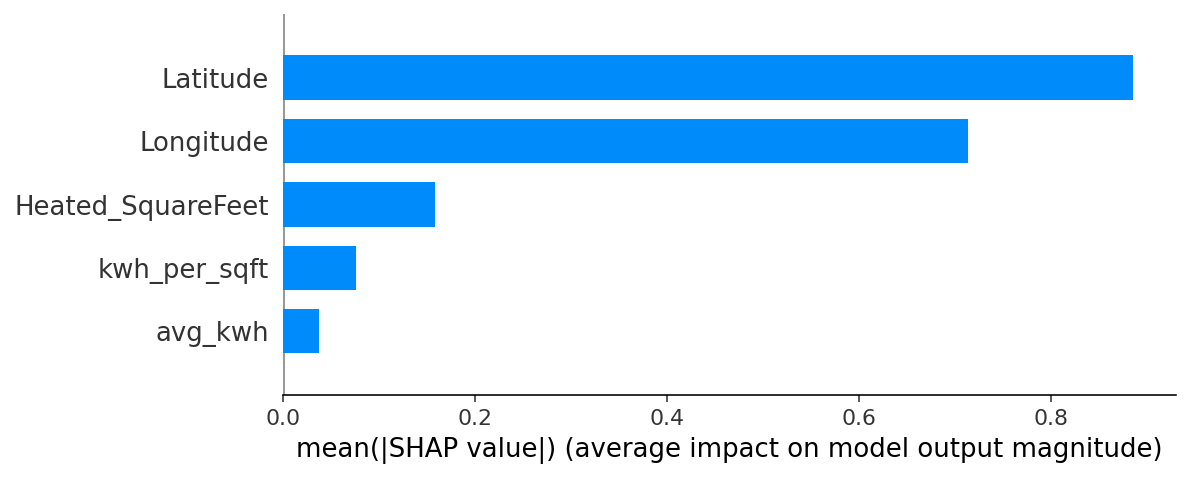

In [30]:
# rf 
shap_values = shap.TreeExplainer(rf_pred).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
#plt.savefig('images/shap_value.png')

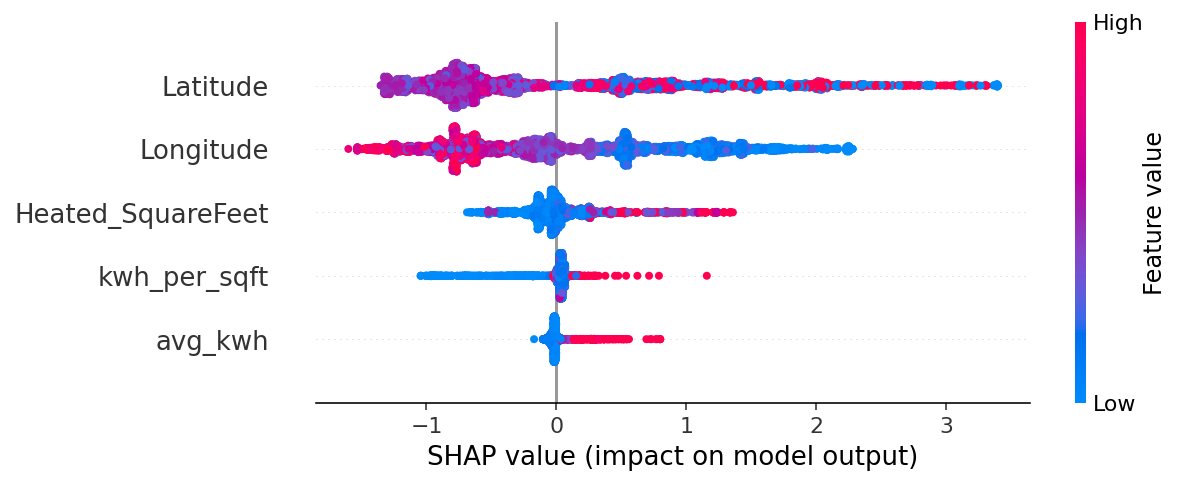

In [31]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train)
#plt.savefig('images/feat_imp_detailed.png')

<h4>Export predictions dataframe</h4>

In [37]:
# export predictions data for use in the carbon zero application
y_hat_pred.to_csv(r'stationary-data/y_hat_pred.csv', header=True)

In [38]:
# export training data to compare to predicted data 
# for efficiency val calc for prioritization of ee impr in Dash app
X_train.to_csv(r'stationary-data/X_train.csv', header=True)

In [39]:
# export y train for actual value in prediction feature engineering
# for efficiency val calc for prioritization of ee impr in Dash app
y_train.to_csv(r'stationary-data/y_train.csv', header=True)

In [40]:
# export training data to compare to predicted data 
# for efficiency val calc for prioritization of ee impr in Dash app
col_kwh_year_df.to_csv(r'stationary-data/col_kwh_year_df.csv', header=True)